# FEV & Smoking:  Regression Modeling

## Eugene Kim

### Introduction

This is an exploratory data analysis of forced expiratory volume (FEV) data taken by Bernard Rosner. This actually represents a subset ofForced expiratory volume is the amount of air a person can exhale in the first second of a forceful breath (in liters), and indicates the person’s level of respiratory function.

This data analysis will focus on the relationship between FEV and smoking. This dataset represents information taken in a cross-sectional study, meaning that we are unable to determine directionality, causality, or more nuanced details about the smoking behavior of individuals. However, we can still do an exploratory analysis to examine correlations that might yield interesting insights into the phenomena. 

From the onset, we already have a sense of the biological rationale for a hypothesis, which is that smoking has negative effects on lung function and would presumably lower the FEV capacity of individuals that smoke. 

In [1]:
library(ggplot2)
library(dplyr)
library(readr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
FEV <- read_csv("~/Desktop/FEV.csv")


FEV$smoke <- factor(FEV$smoke, levels = c("non-current smoker", "current smoker"))
FEV$sex <- factor(FEV$sex, levels = c("female", "male"))


graph1 <- ggplot(FEV, aes(x = smoke, y = fev)) + 
     geom_boxplot(alpha = 0.7, fill = "lightsalmon") + 
     scale_x_discrete(name = "Smoking Status") +
     scale_y_continuous(name = "FEV") +
     ggtitle("FEV by Smoking Status") +
     theme_classic()

Parsed with column specification:
cols(
  id = col_integer(),
  age = col_integer(),
  fev = col_double(),
  height = col_double(),
  sex = col_character(),
  smoke = col_character()
)


smoke: non-current smoker
[1] 2.566143
------------------------------------------------------------ 
smoke: current smoker
[1] 3.276862

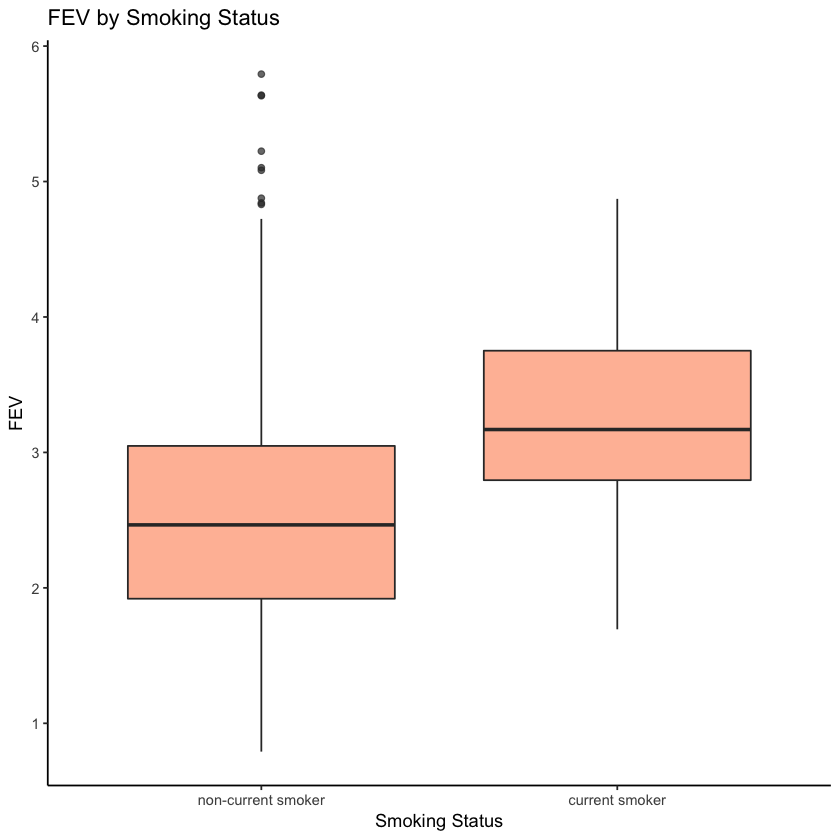

In [3]:
graph1

with(FEV, by(fev, smoke, mean))


A boxplot showing the means and distributions of FEV by smoking status shows that current smokers typically display higher FEVs than non-current smokers, which runs counter to expectations that smoking would decrease the amount of volume that can be forcefully exhaled because of decreased pulmonary function. Further refinement is required to account for other biological factors and potential confounders.

FEV is influenced by other factors as well, such as age and height, which both are related to overall stage of development which includes lung development and capacity. 

### Looking at FEV and Age

                    
                      3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
  non-current smoker  2  9 28 37 54 85 93 76 81 50 30 18  9  6  6  4  1
  current smoker      0  0  0  0  0  0  1  5  9  7 13  7 10  7  2  2  2

smoke: non-current smoker
[1] 9.534805
------------------------------------------------------------ 
smoke: current smoker
[1] 13.52308

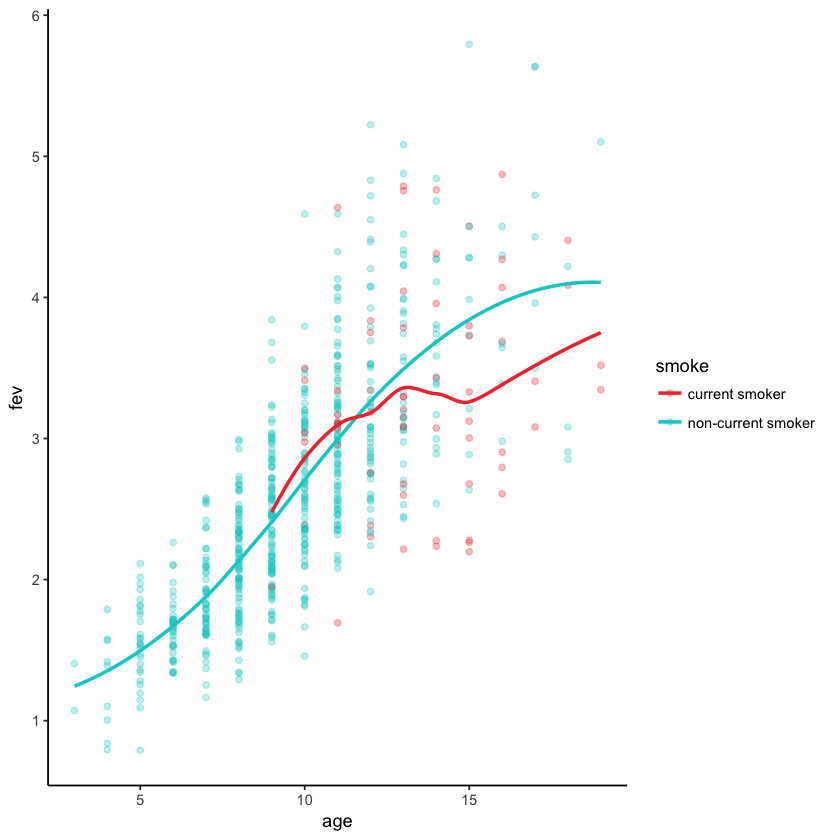

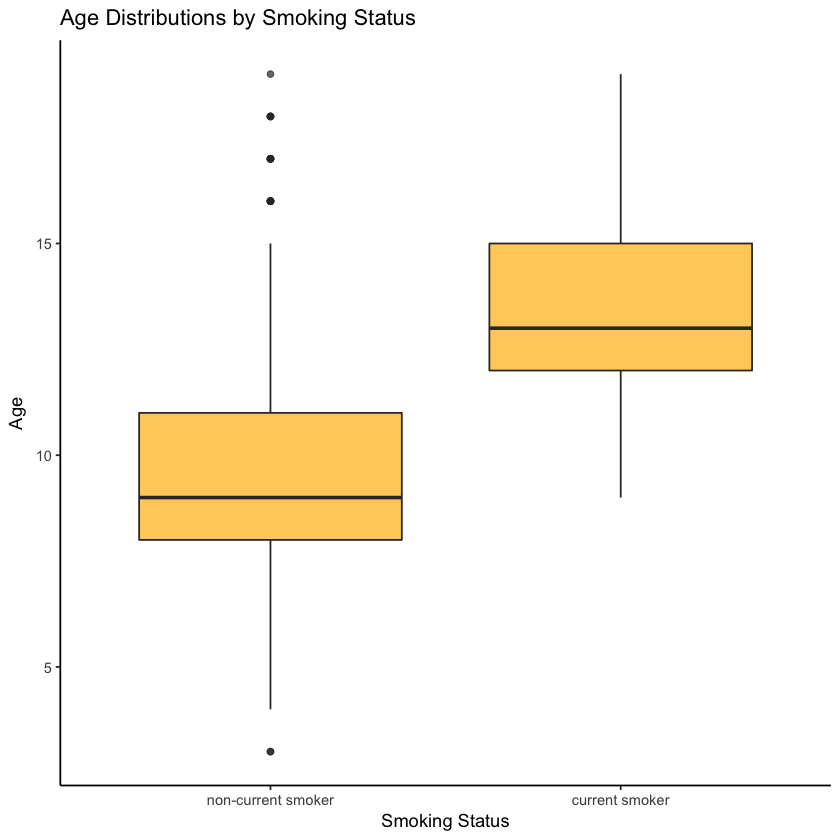

In [30]:
graph2 <- ggplot(FEV, aes(x = age, y = fev, col = smoke)) + 
     geom_point(alpha = 0.3) + 
     scale_color_manual(breaks = c("current smoker", "non-current smoker"), 
                        values = c("cyan3", "brown2")) + 
     geom_smooth(method = "loess", se = F) + 
     theme_classic()

graph2

table(FEV$smoke, FEV$age)
with(FEV, by(age, smoke, mean))

graph3 <- ggplot(FEV, aes(x = smoke, y = age)) + 
          geom_boxplot(alpha = 0.7, fill = "darkgoldenrod1") + 
          scale_x_discrete(name = "Smoking Status") +
          scale_y_continuous(name = "Age") +
          ggtitle("Age Distributions by Smoking Status") +
          theme_classic()

graph3

FEV is positively correlated with age, which conforms to our expectations based on age being a marker of the stage of development. The effect of smoking is masked by the differing age distributions between smokers and non-smokers; current smokers tend to be older than non-current smokers. 

Furthermore, we should question whether it is useful to include an age range that starts at 3 years old. It is much more likely that children of such a young age, particularly below 10 years old, do not smoke. There are no data points in the 3-8 age range for current smokers. You are more likely to see current smokers at later age ranges.

Finally, while a categorical distinction is made between smokers and non-smokers, the extent of the smoking is not specified, i.e., how long have individuals smoked at the time of the report? It is easy to imagine some who have not smoked for a long time, and the effects of smoking have not been established to produce a measurable effect. We also have to consider that there is potential underreporting of smokers (perhaps participants wish not to be identified as underage smokers, even if anonymously), which would bias FEV differences toward zero. 

There seems to be some **interaction** between age and smoke status, as evidenced by the differing slope across levels of the smoke variable. This will need to be investigated further when we conduct regression modeling. 

### FEV and Height
We should also look at the relationship between FEV and height, again stratified by smoking status. Height is a natural surrogate for body size, which is an indicator of childhood development, and by extension, pulmonary development.

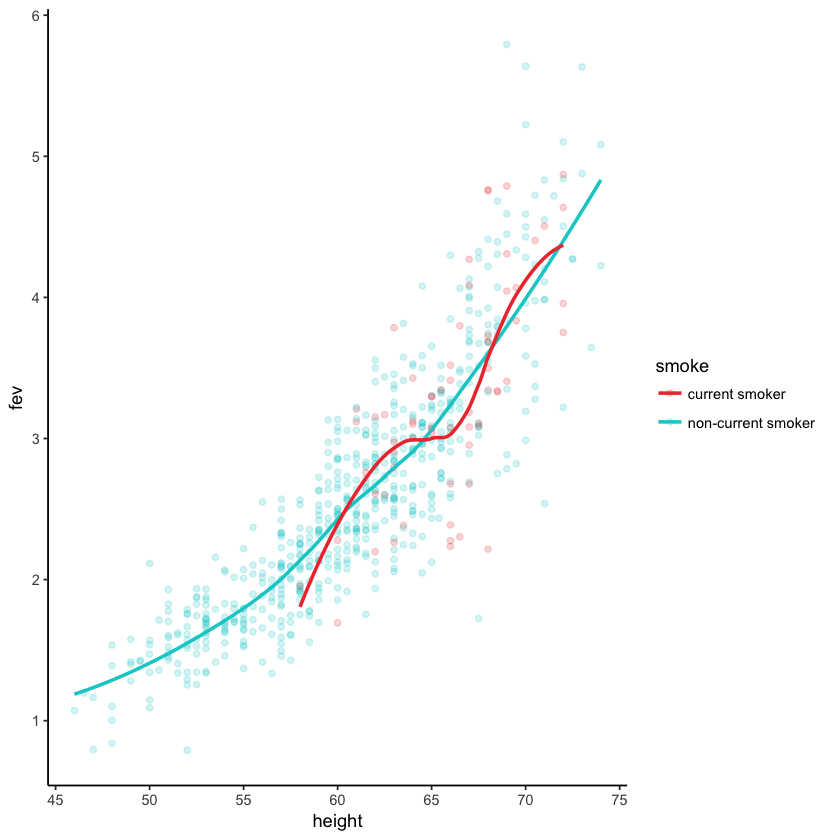

In [6]:
graph4 <- ggplot(FEV, aes(x = height, y = fev, col = smoke)) +
     geom_point(alpha = 0.2) + 
     scale_color_manual(breaks = c("current smoker", "non-current smoker"), values = c("cyan3", "brown2")) +
     geom_smooth(method = "loess", se = F) +
     theme_classic()

graph4

There is significant intermingling and resonating correlation between both smoking categories, which suggests that FEV differences are nominal when accounting for height. Perhaps more than age, height is a closer surrogate to body size and lung size/capacity / stage of development. Furthermore, there seems to be a slight curvilinear relationship in the FEV vs height relationship when using the lowess correlation method. 

We need to control for age and height in the regression model.

### Fitting a Regression Model

We'll include all the variables (sans ID) in the regression model because they are biologically relevant and must be controlled for to isolate the relationship between FEV and smoking. Here, we consider two models, `fit1` and `fit2`. While `fit1` considers height linearly, `fit2` includes height as a quadratic term to account for the slightly curvilinear relationship.

In [7]:
contrasts(FEV$smoke)
contrasts(FEV$sex)

fit1 <- lm(fev ~ smoke + age + height + sex, data = FEV)
summary(fit1)

FEV$height2 <- FEV$height^2

fit2 <- lm(fev ~ smoke + age + height + height2 + sex, data = FEV)
summary(fit2)

,current smoker
non-current smoker,0
current smoker,1


,male
female,0
male,1



Call:
lm(formula = fev ~ smoke + age + height + sex, data = FEV)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.37656 -0.25033  0.00894  0.25588  1.92047 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -4.456974   0.222839 -20.001  < 2e-16 ***
smokecurrent smoker -0.087246   0.059254  -1.472    0.141    
age                  0.065509   0.009489   6.904 1.21e-11 ***
height               0.104199   0.004758  21.901  < 2e-16 ***
sexmale              0.157103   0.033207   4.731 2.74e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4122 on 649 degrees of freedom
Multiple R-squared:  0.7754,	Adjusted R-squared:  0.774 
F-statistic:   560 on 4 and 649 DF,  p-value: < 2.2e-16



Call:
lm(formula = fev ~ smoke + age + height + height2 + sex, data = FEV)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.61190 -0.22716  0.00619  0.22418  1.80565 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          6.8945787  1.4993579   4.598 5.12e-06 ***
smokecurrent smoker -0.1332112  0.0571079  -2.333  0.01997 *  
age                  0.0694646  0.0091089   7.626 8.66e-14 ***
height              -0.2742341  0.0496850  -5.519 4.92e-08 ***
height2              0.0031251  0.0004086   7.649 7.35e-14 ***
sexmale              0.0945352  0.0328613   2.877  0.00415 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3951 on 648 degrees of freedom
Multiple R-squared:  0.794,	Adjusted R-squared:  0.7924 
F-statistic: 499.4 on 5 and 648 DF,  p-value: < 2.2e-16


**Fit1**
The coefficient estimates are all significant against a significance level of 0.05, except the smoke variable (p-value = 0.141). 

**Fit2**
The coefficient estimates are all significant, including the smoke variable, and the fit seems to have improved based on the adjusted R-squared value (0.774 to 0.794). While R-squared values explain the goodness-of-fit, they can be arbitrarily high and should not be taken as evidence of the correctness of the model.

### Fitting a regression model to include interaction.
We saw potentially signficant interaction between age and smoking, so it is prudent to explore that option in our modeling.

In [8]:
fit3 <- lm(fev ~ smoke + age + smoke*age + height + height2 + sex, data = FEV)
summary(fit3)


Call:
lm(formula = fev ~ smoke + age + smoke * age + height + height2 + 
    sex, data = FEV)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6157 -0.2283  0.0103  0.2284  1.7909 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              7.060362   1.504200   4.694 3.28e-06 ***
smokecurrent smoker      0.255544   0.308899   0.827  0.40839    
age                      0.074508   0.009920   7.511 1.95e-13 ***
height                  -0.279539   0.049833  -5.610 3.01e-08 ***
height2                  0.003154   0.000409   7.711 4.72e-14 ***
sexmale                  0.097886   0.032949   2.971  0.00308 ** 
smokecurrent smoker:age -0.029490   0.023029  -1.281  0.20080    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3949 on 647 degrees of freedom
Multiple R-squared:  0.7945,	Adjusted R-squared:  0.7926 
F-statistic: 416.9 on 6 and 647 DF,  p-value: < 2.2e-16


We see that the age-smoke interaction term is not significant (p-value > 0.05) in this model with only a marginal improvement in the fit, so it doesn't seem to be necessary.

### Evaluating Assumptions of the Regression Model
In order for this OLS multiple regression to be the best linear unbiased estimator, several conditions have to hold. 

1. Linearity
2. Normality
3. Homoscedasticity, or constant variance
4. Independence


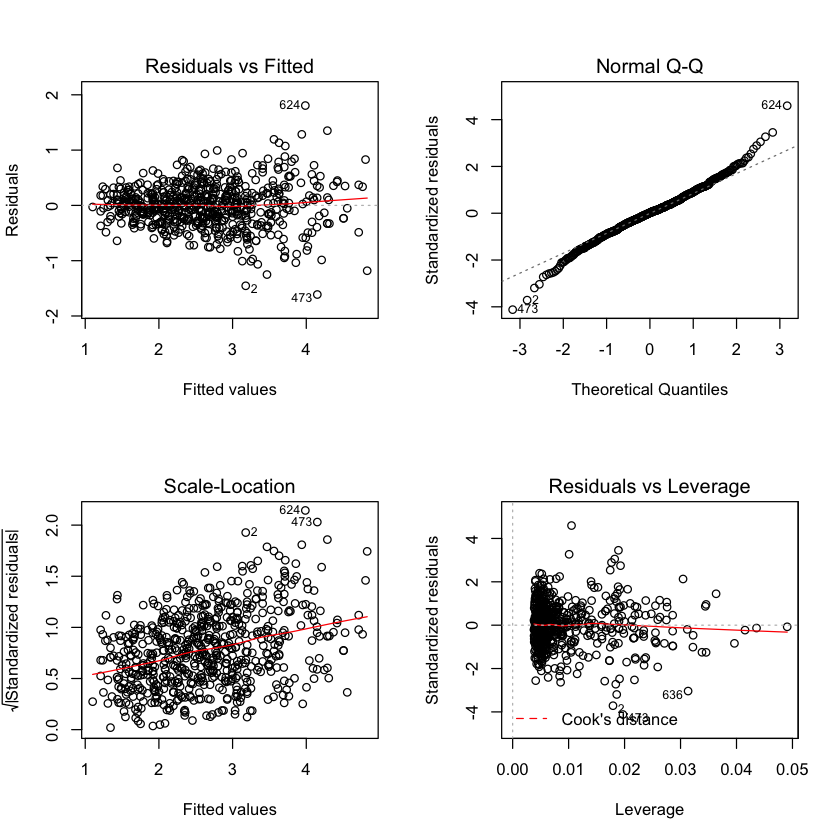

In [9]:
par(mfrow = c(2,2))
plot(fit2)

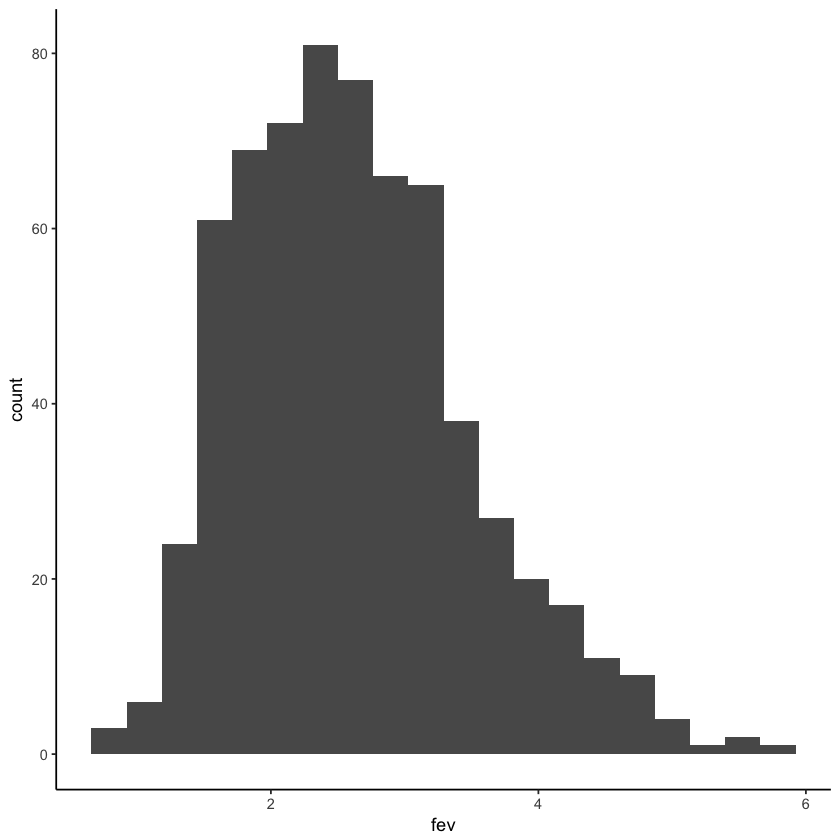

In [29]:
graph5 <- ggplot(FEV, aes(x = fev)) + 
            geom_histogram(bins = 20) +
            theme_classic()

graph5


1. **Homoscedasticity** 
Looking at the residual plot, the assumption of homoscedasticity seems to be violated; we see an expansion of the error across the fitted values of the model. Heteroscedasticity can bias the standard errors and lead to incorrect results from significance tests, confidence intervals, coefficient estimates.  Though OLS is relatively robust method, we should explore variance-stabilizing transformations. 

2. **Normality**  
The QQ plot shows a right-skewed distribution, which is confirmed by a subsequent histogram visualization. 

### Box Cox Method:  Power Transformation
A power transformation seems to be a good fit here, as it addresses both normality deviation and heteroscedasticity. In order to conduct the power transformation , we must find the transformation parameter corresponding to the highest likelihood measure, which will produce the optimal value for the transformation (in this case, -.1414).

From there, we can evaluate the multiple regression assumptions again to see if the linearity and variance have improved. 

lambda,lik
0.14141414,-854.9387
0.10101010,-854.9838
0.18181818,-855.1578
0.06060606,-855.2969
0.22222222,-855.6372
0.02020202,-855.8820


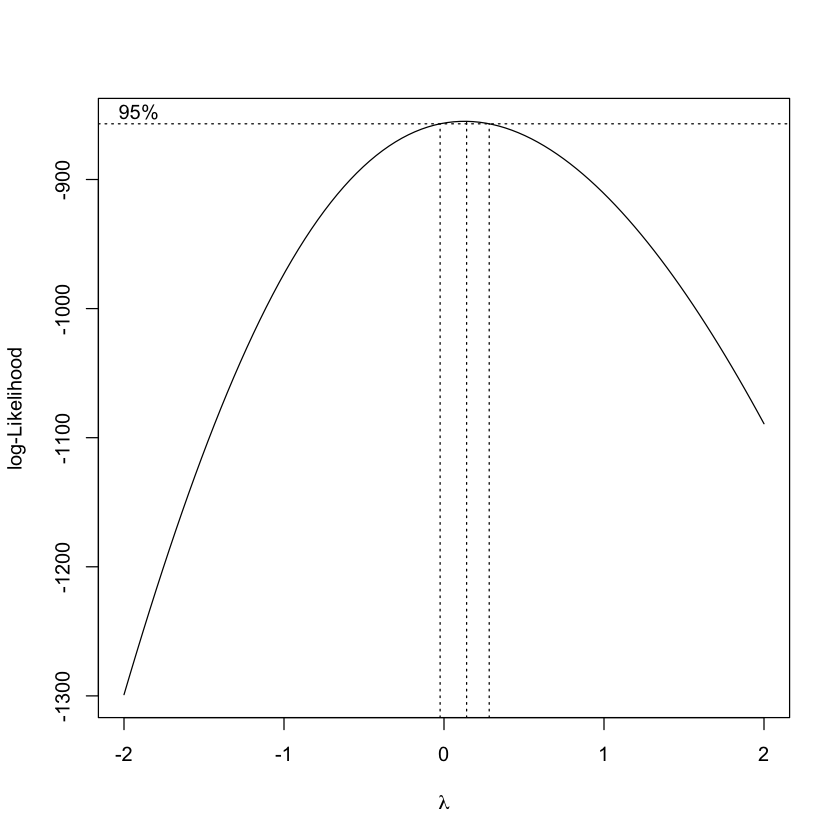

In [19]:
library(MASS) # contains the boxcox() function
b <- boxcox(fev ~ smoke + age + height + height2 + sex, data = FEV)

lambda <- b$x
lik <- b$y
bc <- cbind(lambda, lik)
head(bc[order(-lik),])



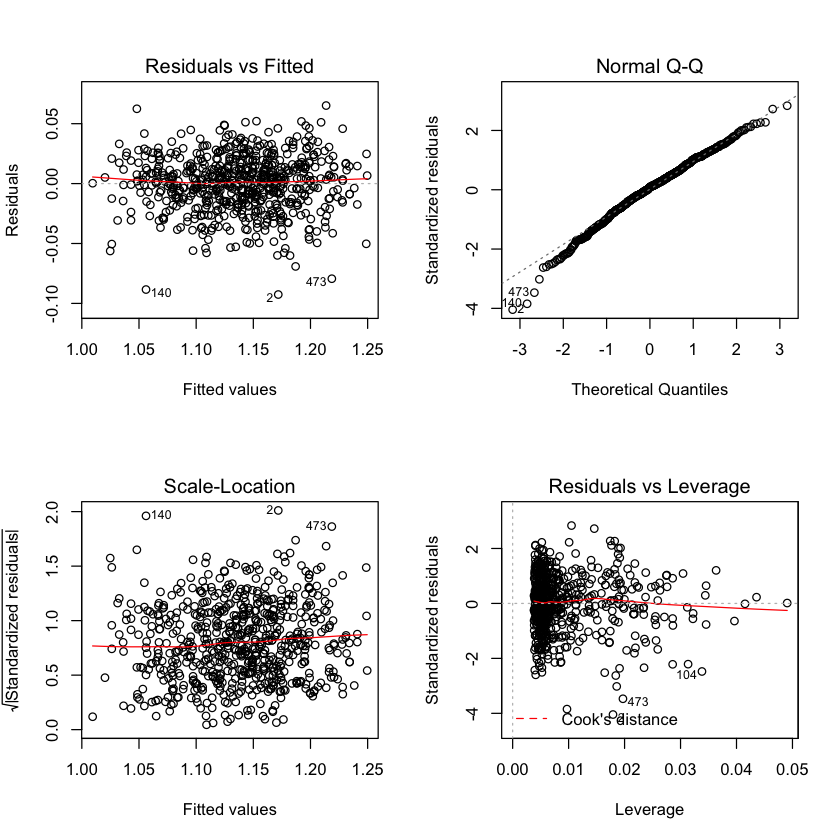

In [22]:
fit.box <- lm(fev^0.14 ~ smoke + age + height + height2 + sex, data = FEV)

par(mfrow = c(2,2))
plot(fit.box)

The diagnostic plots show that the power transformation rectified the issues of heteroscedasticity; the residual plot shows an even distribution of error terms. The skewedness has been significantly reduced; the normal QQ plot shows a much higher adherence to the normal quantiles, indicating variable distribution much closer to Normal.

In [20]:
summary(fit.box)


Call:
lm(formula = fev^0.14 ~ smoke + age + height + height2 + sex, 
    data = FEV)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.092590 -0.013976  0.001939  0.014894  0.065131 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          7.216e-01  8.769e-02   8.229 1.04e-15 ***
smokecurrent smoker -7.138e-03  3.340e-03  -2.137  0.03295 *  
age                  3.771e-03  5.327e-04   7.078 3.82e-12 ***
height               5.560e-03  2.906e-03   1.913  0.05614 .  
height2              9.822e-06  2.389e-05   0.411  0.68115    
sexmale              5.112e-03  1.922e-03   2.660  0.00801 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02311 on 648 degrees of freedom
Multiple R-squared:  0.8104,	Adjusted R-squared:  0.8089 
F-statistic:   554 on 5 and 648 DF,  p-value: < 2.2e-16


The power-transformed model shows an improved fit (adjusted R-squared = 0.8089). However, the utility of the power transformation on the dependent variable comes at a cost of intuitive interpretibility. Across all models that we considered thus far, it was consistent that smoking is associated with decreased FEV capacity, which speaks to the deleterious effect of smoking on respiratory function.

### Discussion


There are more potential options to consider, such as different transformations (e.g., log, cubed) that might produce different fits and varying levels of interpretibility. While we can go down the rabbit hole into these various options, this hopefully shows you the typical workflow of data analysis, moving from exploratory visualizations that lead to modeling of multivariate data using regressions. We considered several models and weighed the merits of each one in predicting the forced expiratory volume. We were able to drill down into the relationship of interest, which was the effect of smoking. The data does show a consistent negative impact on respiratory function as measured by FEV by smoking.